# Functional Connectivity Analysis
***

Now we have an idea of three important components to analyzing neuroimaging data:

1. Data manipulation
2. Cleaning and confound regression
3. Parcellation and signal extraction

In this notebook the goal is to integrate these 3 basic components and perform a full analysis of group data using **Intranetwork Functional Connectivity (FC)**. 

Intranetwork functional connectivity is essentially a result of performing correlational analysis on mean signals extracted from two ROIs. Using this method we can examine how well certain resting state networks, such as the **Default Mode Network (DMN)**, are synchronized across spatially distinct regions. 

ROI-based correlational analysis forms the basis of many more sophisticated kinds of functional imaging analysis.

## Notebook Outline
***

The outline of the notebook is divided into two parts. The first part directly uses what you've learned and builds upon it to perform the final functional connectivity analysis on group data. 

The second part shows how we can use Nilearn's convenient wrapper functionality to perform the same task with *significantly less effort*. 

#### Part A: Manual computation 
1. Functional data cleaning and confound regression
2. Applying a parcellation onto the data
3. Computing the correlation between two ROI time-series


#### Part B: Using Nilearn's high-level features
1. Using NiftiLabelsMasker to extract cleaned time-series
2. Computing the correlation between two ROI time-series
3. Performing analysis on all subjects
4. Visualization of final results

In [28]:
import os
from nilearn import signal as sgl
from nilearn import image as img
from nilearn import plotting as plot
from nilearn import datasets
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bids
%matplotlib inline

In [29]:
#Pick a single subject
fmriprep_dir = '../data/ds000030/'
sub = '10171'

In [30]:
#Use PyBIDS to parse BIDS data structure
layout = bids.BIDSLayout(fmriprep_dir, validate=False)

In [42]:
#Get resting state data (preprocessed, mask, and confounds file)
func_files = layout.get(subject=sub, datatype='func', task='rest',  suffix='preproc')
mask_files = layout.get(subject=sub, datatype='func', task='rest', suffix='brainmask')
confound_files = layout.get(subject=sub, datatype='func', task='rest', suffix='confounds')

In [44]:
#Select MNI files
func_file = func_files[0].path
mask_file = mask_files[0].path
confound_file = confound_files[0].path

### Part A: Manual Computation of Functional Connectivity
***

#### 1. Cleaning your functional data using filtering, dummy TR removal and confound regression
The first step to any functional analysis is to clean the data

We'll define a function to help extract our confound regressors from the .tsv file for us

In [45]:
#Refer to part_06 for code + explanation
def extract_confounds(confound_tsv,confounds,dt=True):
    '''
    Arguments:
        confound_tsv                    Full path to confounds.tsv
        confounds                       A list of confounder variables to extract
        dt                              Compute temporal derivatives [default = True]
        
    Outputs:
        confound_mat                    
    '''
    
    #Load in data using Pandas then extract relevant columns
    confound_df = pd.read_csv(confound_tsv,delimiter='\t') 
    confound_df = confound_df[confounds]
    
    #If using temporal derivatives 
    if dt:
        #For each column create a new column '<colname>_dt' containing the step-wise differences
        for col in confound_df.columns:
            confound_df['{}_dt'.format(col)] = confound_df[col].diff() 
    
    #Convert into a matrix of values (timepoints)x(variable)
    confound_mat = confound_df.values 
    
    #Return confound matrix
    return confound_mat
    

### Exercise:
Let's clean our data!

Settings to use:
- Confounders: X, Y, Z, RotX, RotY, RotZ, aCompCor01, aCompCor02, Global Signal
- Temporal Derivatives: Yes
- high_pass = 0.009
- low_pass = 0.08
- detrend = True
- standardize = True

In [57]:
#Load functional image
tr_drop = 4
func_img = img.load_img(func_file)
func_img = func_img.slicer[:,:,:,tr_drop+1:]

#Extract confounds
confounds = extract_confounds(confound_file,['X','Y','Z','RotX','RotY','RotZ','GlobalSignal',
                                            'aCompCor01','aCompCor02'])
confounds = confounds[tr_drop+1:,:] 

#Clean functional image
clean_img = img.clean_img(func_img,confounds=confounds,low_pass=0.08,high_pass=0.009,t_r=2,
                         mask_img=mask_file) 

#### 2. Setting up the parcellation scheme

To apply a parcellation we'll have to specify a parcellation to use. 
For this analysis we'll be using a spatially separated version [Yeo 2011 - 7 Networks](https://www.ncbi.nlm.nih.gov/pubmed/21653723).

We chose this parcellation since it nicely characterizes the **DMN**, our network of interest.  

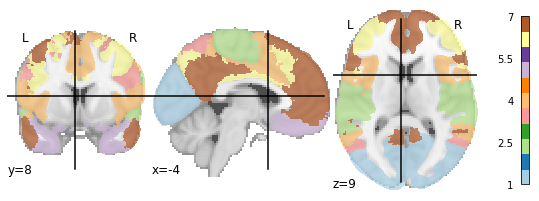

In [48]:
#Examine the original Yeo7 parcellation
net7 = '../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_7Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz'
plot.plot_roi(net7,cmap='Paired',colorbar=True)

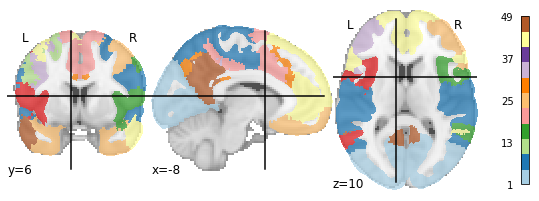

In [49]:
#Load in the spatially separated Yeo 2011 7 networks and view
parcel_file = '../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz' 
yeo_7 = img.load_img(parcel_file)
plot.plot_roi(yeo_7,cmap='Paired',colorbar=True) 

Remember that in order to use the parcellation with our functional data it must have the same dimensions. It turns out that the parcellation schema has slightly different dimensions, so we need to resample: 

In [50]:
#We use "nearest" to preserve the label values (a label of 2.42 for example, doesn't and shouldn't exist) 
resamp_yeo7 = img.resample_to_img(yeo_7,clean_img,interpolation='nearest') 
print(resamp_yeo7.shape)
print(clean_img.shape)

(65, 77, 49)
(65, 77, 49, 147)


#### 3. Intra-network functional connectivity analysis
Intra-network functional connectivity analysis is determined by computing the correlation between the mean time-series of two spatially distinct regions within the same network. 

To perform this analysis requires a few simple steps:
1. Select 2 ROIs from the same network (DMN) 
2. Extract the mean time-series from both regions 
3. Compute the correlation between the two mean ROI time-series

The first step is to select two ROIs from the DMN. We've already gone through the hassle of selecting these two regions but many possible combinations exist. 

In [51]:
#Select two ROIs and visualize
source_ROI = 44
target_ROI = 46

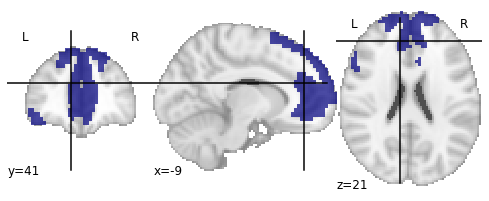

In [52]:
#Visualize the ROI, we can do this by masking our all values not matching our ROI
source_mask = img.math_img('a == {}'.format(source_ROI), a=resamp_yeo7) 

#Apply the mask to the data
masked_source = img.math_img('a*b',a=resamp_yeo7,b=source_mask) 

#Visualize
plot.plot_roi(masked_source) 

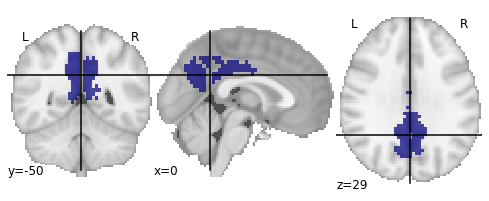

In [53]:
target_mask = img.math_img('a == {}'.format(target_ROI),a=resamp_yeo7)
masked_target = img.math_img('a*b',a=resamp_yeo7,b=target_mask)
plot.plot_roi(masked_target)

With our two regions selected, we'll now extract the mean time-series for each of our two ROIs

In [54]:
#Recall that in the parcellation, each voxel is labelled with a number corresponding to a distinct parcel
#We want to extract parcels belonging to our ROI.

#Pull the voxels indices belonging to the ROI 
yeo7_data = resamp_yeo7.get_data() 

#Get voxel coordinates (x,y,z) list of source and target ROIs
source_roi = np.where(yeo7_data == source_ROI)
target_roi = np.where(yeo7_data == target_ROI)

#Load up functional data to extract ROI voxels from
func_data = clean_img.get_data()

#Extract the list of voxel time-series belonging to each ROI
#This is now a (roi voxel)x(timepoints) array
source_ts = func_data[source_roi]
target_ts = func_data[target_roi] 

#We want to compute the mean timeseries of each list of voxels (source and target) 
#This will be a (1) x (timepoints) vector
mean_source_ts = np.mean(source_ts,axis=0)
mean_target_ts = np.mean(target_ts,axis=0) 

Now we've extracted two average time-series, one from the source, and one from the target.
The last step is to compute the correlation between them. This will tell us how well the average time-series from the two DMN regions synchronize with each other.

To do this we use <code>np.corrcoef(x,y)</code> which returns a matrix of form:

$$ \rho=
\left( \begin{matrix}
\rho_{1,1} & \rho_{1,2} \\
\rho_{2,1} & \rho_{2,2}
\end{matrix} \right)
$$

The diagonals represent the correlation of signals with themselves. These are always $1$. The off-diagonal represents the correlation of one signal with another is exactly what we want. In addition the matrix is symmetric so: $\rho_{1,2} = \rho_{2,1}$. 

In [58]:
#Compute correlation and pull the value in the first row, second column
correlation_matrix = np.corrcoef(mean_source_ts,mean_target_ts)
source_targ_corr = correlation_matrix[0,1]
print(source_targ_corr)

0.2491518233005721


### Part B: Using nilearn's Labels Masker to extract the timeseries
***
nilearn has a built in function for extracting timeseries from functional files and doing a little extra signal processing at the same time!

First we import a package from <code>nilearn</code>, called <code>input_data</code> which allows us to pull data using the parcellation file, and at the same time applying data cleaning!

We first create an object using the parcellation file <code>yeo_7</code> and our cleaning settings which are the following:

Settings to use:
- Confounders: X, Y, Z, RotX, RotY, RotZ, aCompCor01, aCompCor02, Global Signal
- Temporal Derivatives: Yes
- high_pass = 0.009
- low_pass = 0.08
- detrend = True
- standardize = True


In [56]:
from nilearn import input_data

masker = input_data.NiftiLabelsMasker(labels_img=yeo_7,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      verbose=1,
                                      detrend=True,
                                     low_pass = 0.08,
                                     high_pass = 0.009,
                                     t_r=2)

The object <code>masker</code> is now able to be used on *any functional image of the same size*. What it means to *use the masker* is that you can automatically *apply a parcellation and extract data at the same time*. We'll specify the confound variables we'll use in a moment:

### Using nilearn's ConnectivityMeasure to calculate our correlation matrix

The second step is to compute the functional connectivity (correlation) matrix. When we use <code>masker</code>, we can compute the correlation matrix *between all ROIs in our parcellation atlas at the same time*. Below we'll show an example on how to use the <code>masker</code> in order to compute correlations on our data:

First we'll automatically clean and average data for each of our ROIs at the same time. This is done using <code>masker.fit_transform</code>:

In [59]:
cleaned_and_averaged_time_series = masker.fit_transform(func_img, confounds)
cleaned_and_averaged_time_series.shape

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
Resampling labels


/home/jerry/.pyenv/versions/3.6.0/envs/scwg_neuroimaging/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:129: UserWarning: Incompatible cache in nilearn_cache/joblib: different version of nibabel. Deleting the cache. Put nilearn.CHECK_CACHE_VERSION to false to avoid this behavior.
  % cachedir)


________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f2729fe7860>, <nilearn.input_data.nifti_labels_masker._ExtractionFunctor object at 0x7f272a835b00>, 
{ 'background_label': 0,
  'detrend': True,
  'dtype': None,
  'high_pass': 0.009,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x7f272a1388d0>,
  'low_pass': 0.08,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': 2,
  'target_affine': None,
  'target_shape': None}, confounds=array([[ 0.000611, ..., -0.018387],
       ...,
       [ 0.3179  , ..., -0.027444]]), dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(65, 77, 49, 147),
affine=array([[   3.,    0.,    0.,  -96.],
       [   0.,    3.,    0., -132.],
       [   0.,    0.,  

/home/jerry/.pyenv/versions/3.6.0/envs/scwg_neuroimaging/lib/python3.6/site-packages/nilearn/input_data/nifti_labels_masker.py:269: UserWarning: Persisting input arguments took 0.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


(147, 46)

Then using this data we can calculate a *full correlation matrix* - this is the correlation between *all pairs of ROIs* in our parcellation scheme! We'll use another nilearn tool called <code>ConnectivityMeasure</code> from <code>nilearn.connectome</code>

In [60]:
from nilearn.connectome import ConnectivityMeasure

Like the masker, we need to make an object that will calculate connectivity for us:

In [61]:
correlation_measure = ConnectivityMeasure(kind='correlation')

Then we use <code>correlation_measure.fit_transform()</code> in order to calculate the full correlation matrix for our parcellated data!

In [63]:
full_correlation_matrix = correlation_measure.fit_transform([cleaned_and_averaged_time_series])
full_correlation_matrix.shape

(1, 46, 46)

***
Note that we're using a list <code>[cleaned_and_averaged_time_series]</code>, this is becasue <code>correlation_measure</code> works on a *list of subjects*. We'll take advantage of this later!
***

The result is a matrix which has:

- A number of rows matching the number of ROIs in our parcellation atlas
- A number of columns, that also matches the number of ROIs in our parcellation atlas

You can read this correlation matrix as follows:

- Suppose we wanted to know the correlation between ROI 30 and ROI 40
- Then Row 30, Column 40 gives us this correlation. 
- Row 40, Column 40 can also give us this correlation

This is because the correlation of $A \to B = B \to A$

***

### Exercise: Now try calculating correlation matrices for all subjects in our dataset!

We've provided some skeleton code to handle some of the logic. Try to fill in the blanks to the best of your ability!

In [ ]:
subjects = layout.get_subjects()

In [ ]:
pooled_subjects = []
ctrl_subjects = []
schz_subjects = []

for sub in subjects:
    func_file = layout.get(subject=sub, modality='func',
                           type='preproc', return_type='file')[0]
    
    confound_file=layout.get(subject=sub, modality='func',
                             type='confounds', return_type='file')[0]
    
    func_img = img.load_img(func_file)
    func_img = func_img.slicer[:,:,:,tr_drop+1:]
    
    confounds = extract_confounds(confound_file,
                                 ['X','Y','Z',
                                 'RotX','RotY','RotZ',
                                 'GlobalSignal','aCompCor01',
                                 'aCompCor02'])
    
    confounds = confounds[tr_drop+1:,:]
    
    time_series = masker.fit_transform(func_img,confounds)
    pooled_subjects.append(time_series)
    
    if sub.startswith('1'):
        ctrl_subjects.append(time_series)
    if sub.startswith('5'):
        schz_subjects.append(time_series)

A helpful trick is that we can re-use the <code>correlation_measure</code> object we made earlier and apply it to a *list of subject data*! 

In [ ]:
ctrl_correlation_matrices = correlation_measure.fit_transform(ctrl_subjects)
schz_correlation_matrices = correlation_measure.fit_transform(schz_subjects)

At this point, we have correlation matrices for each subject across two populations. The final step is to examine the differences between these groups in their correlation between ROI 43 and ROI 45:

***

### Visualizing Correlation Matrices and Group Differences

An important step in any analysis is visualizing the data that we have. We've cleaned data, averaged data and calculated correlations but we don't actually know what it looks like! Visualizing data is important to ensure that we don't throw pure nonsense into our final statistical analysis

To visualize data we'll be using a python package called <code>seaborn</code> which will allow us to create statistical visualizations pretty easily

In [ ]:
import seaborn as sns

In [ ]:
def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        plot.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                             title=title, figure=fig, colorbar=False)

In [ ]:
plot_matrices(ctrl_correlation_matrices, 'correlation')

In [ ]:
plot_matrices(schz_correlation_matrices, 'correlation')

In [ ]:
ctrl_correlation_matrices.shape

Now that we have the full set of connectivity values across multiple ROIs, we'd like to pull matrices specific to the ROI's of interest (44,46). 
We'll first pull the set of intra-network connectivities for our two ROIs of interest. 

In [ ]:
ctrl_roi_vec = ctrl_correlation_matrices[:,43,45]
schz_roi_vec = schz_correlation_matrices[:,43,45]

Now we'll visualize the final results using Seaborn

In [ ]:
import seaborn as sns

Seaborn visualization is best achieved using a Pandas dataframe (much like R's dataframes). A dataframe is essentially a spreadsheet-like table and is easily created using numpy arrays.

In [ ]:
#Create control dataframe
ctrl_df = pd.DataFrame(data={'dmn_corr':ctrl_roi_vec, 'group':'control'})
scz_df = pd.DataFrame(data={'dmn_corr':schz_roi_vec, 'group' : 'schizophrenia'})

In [ ]:
#Stack the two dataframes together
df = pd.concat([ctrl_df,scz_df],ignore_index=True)
df.sample(n=5)

In [ ]:
#Visualize results
plot = plt.figure(figsize=(5,5))
ax = sns.boxplot(x='group',y='dmn_corr',data=df,palette='Set3')
ax = sns.swarmplot(x='group',y='dmn_corr',data=df,color='0.25')
ax.set_title('DMN Intra-network Connectivity')
ax.set_ylabel(r'Intra-network connectivity $\mu_\rho$')
plt.show()

### Computing correlations was simple, but interpreting results... 
# "Science is hard" - Colin Hawco